# Fitting models using MCMC, and generating posterior predictions

## First steps

### Python dependencies

In [2]:
import os
os.chdir('..')
    # run initially as cd will be the notebook folder otherwise
%load_ext rpy2.ipython
    # warnings about 'quartz' on Windows can be safely ignored.

pal = ["#ffc9b5", "#648767", "#b1ddf1", "#95a7ce", "#987284", "#3d5a80"]
light_pal = ["#ffc9b5", "#b1ddf1", "#987284"]

c:\users\qderc\appdata\local\programs\python\python39\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


### Load pstpipeline package

In [52]:
%%R
devtools::load_all()
options(mc.cores = 4) # number of chains to run in parallel

i Loading pstpipeline


### Get a subsample of the dataset

For computational ease, we are going to take a small sample (n=20) of each of our cohorts, as each model otherwise takes >=1 day to run on standard hardware!

In [3]:
%%R
data(pstpipeline::all_res_split)
nd_subsample <- pstpipeline::take_subsample(
    all_res_split$non_distanced, n_ppts = 20
)
dis_subsample <- pstpipeline::take_subsample(
    all_res_split$distanced, n_ppts = 20
)

In [4]:
%%R
head(nd_subsample$ppt_info)

# A tibble: 6 x 78
  subjID   sessionID  studyID  distanced exclusion final_block_AB final_block_CD
  <chr>    <chr>      <chr>    <lgl>         <dbl>          <dbl>          <dbl>
1 601c7eb~ 60816ff3a~ 60801f5~ FALSE             0           0.95          0.85 
2 5c029fd~ 607ec0aed~ 607eb5f~ FALSE             0           0.55          0.5  
3 5ff5ce0~ 60891cb39~ 608006e~ FALSE             0           0.55          0.737
4 5f09db2~ 60891a9ca~ 608009d~ FALSE             0           1             0.95 
5 5e04b21~ 60891a9e2~ 608009d~ FALSE             0           1             0.9  
6 5e67667~ 609102999~ 607ffa7~ FALSE             0           0.85          0.8  
# ... with 71 more variables: final_block_EF <dbl>, total_points <int>,
#   total_time_taken <dbl>, keypress_percent <dbl>, mean_rt <dbl>,
#   digit_span <int>, catch_question_1 <lgl>, catch_question_2 <lgl>,
#   catch_question_3 <lgl>, catch_question_4 <lgl>, sex <chr>, age <int>,
#   gender <chr>, ethnicity <chr>, ses <int>, inco

## Q-learning models: background

Model-free reinforcement learning (RL) in the PST is commonly modelled using Q-learning (QL) models. 

In QL models, the weight or Q-value $Q_t(s_t, a_t)$ for a given action $a$ in state $s$ at time $t$ is an estimate of the state-action value, which can in turn be understood as an estimate of the expected sum of future rewards, conditional on that action at time $t$. Q-values are updated trial-by-trial based on prediction errors $\delta_t$:

$Q_{t+1}(s_t, a_t) = Q_t(s_t, a_t) + \alpha\delta_t$

Here, $\alpha$ is the learning rate - in this task, lower values suggest that Q-values are being integrated more over time, while higher values indicate higher sensitivity to recent trials. In bandit tasks such as the PST, it can be shown that selecting a certain action/choice does not affect the transition to future states ([Sutton & Barto, 1998](https://mitpress.mit.edu/books/reinforcement-learning)), and so $\delta_t$ can be given as follows, where $r_t$ is the reward (i.e., positive or negative feedback) obtained at time $t$:

$\delta_t = r_t - Q_t(s_t, a_t)$

Given Luce's choice axiom$^1$, these state-action values can be converted to probabilities using a softmax function for a binary choice:

$P_t(s_t, a_t) = \frac{\exp{(Q_t(s_t, a_t)*\beta})}{1-\exp{(Q_t(s_t, a_t)*\beta})}$

where $\beta$ is an inverse temperature parameter, lower values of which indicate higher stochasticity in choices. Taking logits, it can be shown that this simplifies to the following, where $b_t$ is the alternative (avoided) choice in the pair:

$logit[P_t(s_t, a_t)] = \beta[Q_t(s_t, a_t) - Q_t(s_t, b_t)]$

In all of the following code blocks, the Q-learning models are fitted in a hierarchical Bayesian manner, with uninformative group-level priors on each of the parameters of interest; the trials are iterated over, and the posterior density updated assuming the chosen option follows a Bernoulli logistic distribution with the chance-of-success parameter = $\beta[Q_t(s_t, a_t) - Q_t(s_t, b_t)]$.

$^1$The absence of other symbols from the choices at each trial is assumed to not affect the probability of chosing one over the other.

# Training data

## 2 learning rates

The primary model of interest for the training phase of the PST is an extended QL model with two learning rates: $\alpha_{gain}$ and $\alpha_{loss}$ ([Frank et al., 2007](https://www.pnas.org/content/104/41/16311)). In this model, two different parameters are used to update the state-action values:

$Q_{t+1}(s_t, a_t) = \left\{ \begin{array}{ll}
Q_t(s_t, a_t) + \alpha_{gain}\delta_t & \text{if } \delta_t \geq  0, \text{ or} \\
Q_t(s_t, a_t) + \alpha_{loss}\delta_t & \text{if } \delta_t < 0 \end{array} \right.$

As $\delta_t < 0$ only when feedback is negative (i.e., $r_t$ = 0), higher $\alpha_{loss}$ values can be interpreted as increased sensitivity to recent negative feedback (and so reduced integration over trials), while higher $\alpha_{loss}$ values suggest increased sensitivity to recent positive feedback.

### Model fits

#### Non-distanced participants

In [5]:
%%R
# install.packages("bayesplot") # required if model_checks=TRUE
subset_mcmc_2a_train_nd <- pstpipeline::fit_learning_model(
    nd_subsample, model = "2a", exp_part = "training", vb = FALSE, 
    save_model_as = "fit_pst_2a_nd_subsamp", model_checks = TRUE,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj", 
                "diagnostics"), 
    out_dir = "outputs/cmdstan/2a_subset/model_fits", refresh = 0, iter_warmup = 1000, 
    iter_sampling = 2000, adapt_delta = 0.9, step_size = 1, max_treedepth = 10, 
    font_size = 11, font = "Open Sans"
);

R[write to console]: The C++ toolchain required for CmdStan is setup properly!

R[write to console]: Compiling Stan program...



R[write to console]: Getting initial values from variational inference...



Finished in  14.4 seconds.
Running MCMC with 4 parallel chains...

Chain 1 finished in 1049.6 seconds.
Chain 3 finished in 1177.5 seconds.
Chain 2 finished in 1184.5 seconds.
Chain 4 finished in 1275.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1171.8 seconds.
Total execution time: 1275.8 seconds.
Processing csv files: C:/Users/qderc/Documents/Research Work/October 2021/pstpipeline/outputs/cmdstan/2a_subset/model_fits/pst_gainloss_Q_training-202110291503-1-7c6c3f.csv, C:/Users/qderc/Documents/Research Work/October 2021/pstpipeline/outputs/cmdstan/2a_subset/model_fits/pst_gainloss_Q_training-202110291503-2-7c6c3f.csv, C:/Users/qderc/Documents/Research Work/October 2021/pstpipeline/outputs/cmdstan/2a_subset/model_fits/pst_gainloss_Q_training-202110291503-3-7c6c3f.csv, C:/Users/qderc/Documents/Research Work/October 2021/pstpipeline/outputs/cmdstan/2a_subset/model_fits/pst_gainloss_Q_training-202110291503-4-7c6c3f.csv

Checking sampler transitions treedepth.
T

#### Distanced participants

In [6]:
%%R
subset_mcmc_2a_train_dis <- pstpipeline::fit_learning_model(
    dis_subsample, model = "2a", exp_part = "training", vb = FALSE, 
    save_model_as = "fit_pst_2a_dis_subsamp", model_checks = TRUE,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj", 
                "diagnostics"), 
    out_dir = "outputs/cmdstan/2a_subset/model_fits", refresh = 0, iter_warmup = 1000, 
    iter_sampling = 2000, adapt_delta = 0.9, step_size = 1, max_treedepth = 10, 
    font_size = 11, font = "Open Sans"
);

R[write to console]: The C++ toolchain required for CmdStan is setup properly!

R[write to console]: Model executable is up to date!

R[write to console]: Getting initial values from variational inference...



Finished in  20.7 seconds.
Running MCMC with 4 parallel chains...

Chain 1 finished in 1131.7 seconds.
Chain 3 finished in 1152.0 seconds.
Chain 2 finished in 1249.0 seconds.
Chain 4 finished in 1288.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1205.4 seconds.
Total execution time: 1289.1 seconds.
Processing csv files: C:/Users/qderc/Documents/Research Work/October 2021/pstpipeline/outputs/cmdstan/2a_subset/model_fits/pst_gainloss_Q_training-202110291531-1-278f3a.csv, C:/Users/qderc/Documents/Research Work/October 2021/pstpipeline/outputs/cmdstan/2a_subset/model_fits/pst_gainloss_Q_training-202110291531-2-278f3a.csv, C:/Users/qderc/Documents/Research Work/October 2021/pstpipeline/outputs/cmdstan/2a_subset/model_fits/pst_gainloss_Q_training-202110291531-3-278f3a.csv, C:/Users/qderc/Documents/Research Work/October 2021/pstpipeline/outputs/cmdstan/2a_subset/model_fits/pst_gainloss_Q_training-202110291531-4-278f3a.csv

Checking sampler transitions treedepth.
T

### Model checks and comparisons

#### Posterior distributions of parameter means

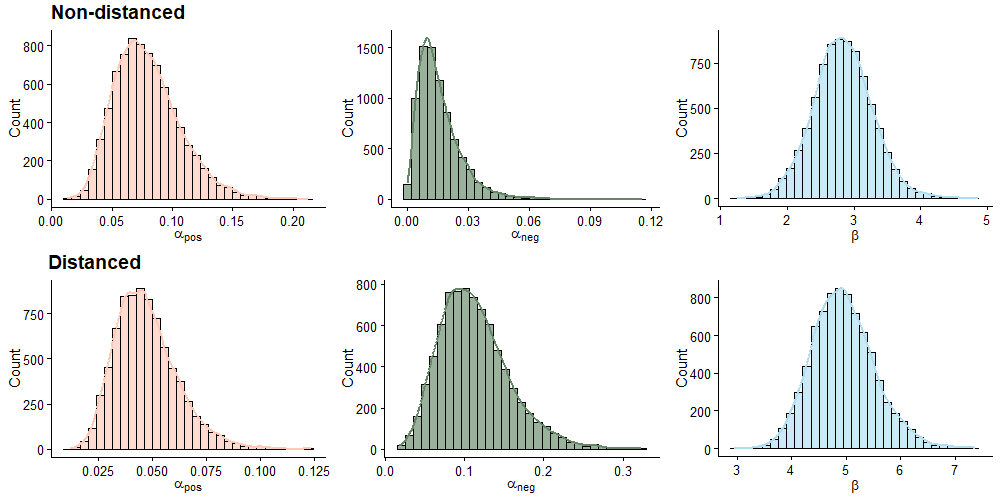

In [7]:
%%R -w 10 -h 5 --units in -r 100
cowplot::plot_grid(
    cowplot::ggdraw() + cowplot::draw_label(
        "Non-distanced", hjust = 3.35, fontface = "bold", size = 14, 
        fontfamily = "Open Sans"
    ),
    subset_mcmc_2a_train_nd$model_checks$mu_par_dens,
    cowplot::ggdraw() + cowplot::draw_label(
        "Distanced", hjust = 4.85, fontface = "bold", size = 14, 
        fontfamily = "Open Sans"
    ),
    subset_mcmc_2a_train_dis$model_checks$mu_par_dens,
    nrow = 4,
    rel_heights = c(0.1, 1, 0.1, 1)
)

These are the posterior distributions for the group-level means of the three free parameters. Notably, the posterior mean distribution for $\alpha_{loss}$ is lower than for $\alpha_{gain}$, suggesting the recency effect is stronger for positive feedback.

#### MCMC diagnostics

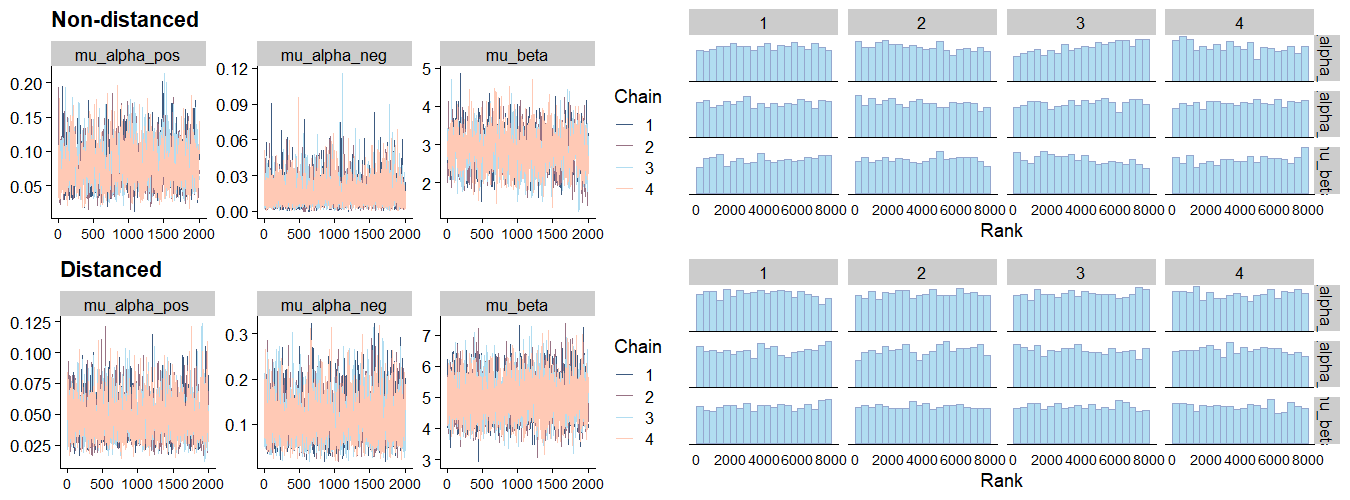

In [8]:
%%R -w 13.5 -h 5 --units in -r 100
cowplot::plot_grid(
    subset_mcmc_2a_train_nd$model_checks$diagnostics$trace + 
        ggplot2::ggtitle("Non-distanced") + 
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)), 
    subset_mcmc_2a_train_nd$model_checks$diagnostics$rank_hist +
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)),
    subset_mcmc_2a_train_dis$model_checks$diagnostics$trace + 
        ggplot2::ggtitle("Distanced") +
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)), 
    subset_mcmc_2a_train_dis$model_checks$diagnostics$rank_hist + 
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)),
    nrow = 2,
    ncol = 2
)

Traces should look like "hairy caterpillars", and rank histograms should all be approximately uniformly distributed (here, it may be that we should do more sampling/warm-up iterations). Next, we want to see how well the fitted model parameters predict the observed data, by sampling from the posterior.

### Generate and plot posterior predictions

#### Sample from fitted model object

In [6]:
%%R
fit_nd_2a <- readRDS(
    "outputs/cmdstan/2a_subset/model_fits/fit_pst_2a_nd_subsamp_mcmc_8000.RDS"
)
data_list_nd_2a <- readRDS(
    "outputs/cmdstan/2a_subset/model_fits/fit_pst_2a_nd_subsamp_stan_datalist.RDS"
)

subset_gq_2a_train_nd <- pstpipeline::generate_posterior_quantities(
    fit_mcmc = fit_nd_2a, data_list = data_list_nd_2a, 
    save_model_as = "fit_pst_2a_nd_subsamp", 
    out_dir = "outputs/cmdstan/2a_subset/predictions", return_type = "paths"
)

R[write to console]: Model executable is up to date!



Running standalone generated quantities after 4 MCMC chains, all chains in parallel ...

Chain 1 finished in 0.0 seconds.
Chain 4 finished in 0.0 seconds.
Chain 3 finished in 0.0 seconds.
Chain 2 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 30.4 seconds.


In [58]:
%%R
fit_dis_2a <- readRDS(
    "outputs/cmdstan/2a_subset/model_fits/fit_pst_2a_dis_subsamp_mcmc_8000.RDS"
)
data_list_dis_2a <- readRDS(
    "outputs/cmdstan/2a_subset/model_fits/fit_pst_2a_dis_subsamp_stan_datalist.RDS"
)

subset_gq_2a_train_dis <- pstpipeline::generate_posterior_quantities(
    fit_mcmc = fit_dis_2a, data_list = data_list_dis_2a, 
    save_model_as = "fit_pst_2a_dis_subsamp", 
    out_dir = "outputs/cmdstan/2a_subset/predictions", return_type = "paths"
)

R[write to console]: Model executable is up to date!



Running standalone generated quantities after 4 MCMC chains, all chains in parallel ...

Chain 1 finished in 0.0 seconds.
Chain 4 finished in 0.0 seconds.
Chain 2 finished in 0.0 seconds.
Chain 3 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 30.2 seconds.


#### Get and save posterior predictions

In [59]:
%%R
obs_nd <- readRDS(
    "outputs/cmdstan/2a_subset/model_fits/fit_pst_2a_nd_subsamp_raw_df.RDS"
)
obs_dis <- readRDS(
    "outputs/cmdstan/2a_subset/model_fits/fit_pst_2a_dis_subsamp_raw_df.RDS"
)

obs_df_preds_nd_2a <- pstpipeline::get_preds_by_chain(
    subset_gq_2a_train_nd, obs_df = obs_nd, n_draws_chain = 2000, 
    prefix = "nd_", save_dir = "outputs/cmdstan/2a_subset/predictions",
)
obs_df_preds_dis_2a <- pstpipeline::get_preds_by_chain(
    subset_gq_2a_train_dis, obs_df = obs_dis, n_draws_chain = 2000, 
    prefix = "dis_", save_dir = "outputs/cmdstan/2a_subset/predictions" 
)

R[write to console]: Finished in 133.1 seconds.

R[write to console]: Finished in 134.4 seconds.



#### Plot predictions

In [60]:
%%R
pred_plts_2a_nd <- pstpipeline::plot_ppc(
    train_indiv = list(obs_df_preds_nd_2a$indiv_obs_df, c(20, 120), c(20, 120)),
    train_trials = list(obs_df_preds_nd_2a$trial_obs_df, "all_trials"),
    font = "Open Sans", font_size = 11
)
pred_plts_2a_dis <- pstpipeline::plot_ppc(
    train_indiv = list(obs_df_preds_dis_2a$indiv_obs_df, c(20, 120), c(20, 120)),
    train_trials = list(obs_df_preds_dis_2a$trial_obs_df, "all_trials"),
    font = "Open Sans", font_size = 11
)

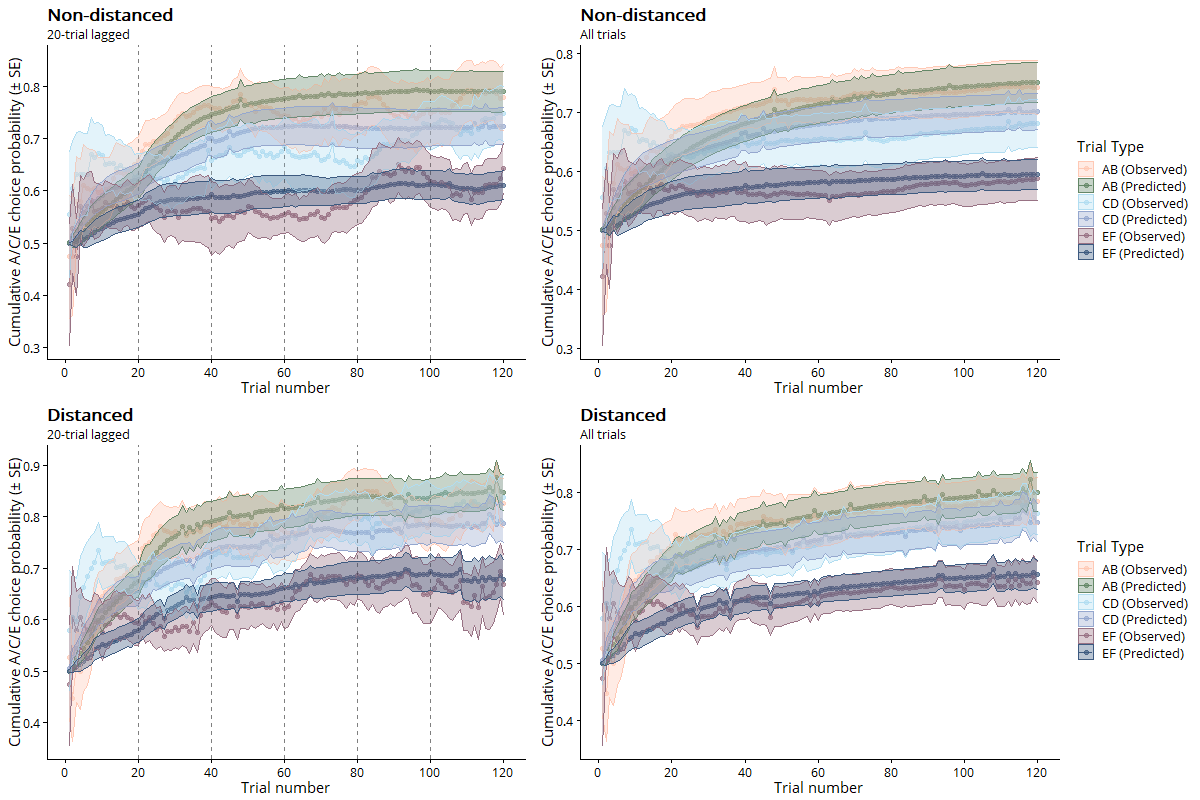

In [83]:
%%R -w 12 -h 8 --units in -r 100
legend <- cowplot::get_legend(
  pred_plts_2a_nd$training_cum_prob[[1]] + ggplot2::theme(
      legend.box.margin = ggplot2::margin(0, 0, 0, 8)
  )
)

cowplot::plot_grid(
    pred_plts_2a_nd$training_cum_prob[[1]] + 
        ggplot2::theme(legend.position="none") + 
        ggplot2::ggtitle("Non-distanced", 
                         subtitle = "20-trial lagged"), 
    pred_plts_2a_nd$training_cum_prob[[2]] + 
        ggplot2::theme(legend.position="none") + 
        ggplot2::ggtitle("Non-distanced", 
                         subtitle = "All trials"),
    legend,
    pred_plts_2a_dis$training_cum_prob[[1]] + 
        ggplot2::theme(legend.position="none") + 
        ggplot2::ggtitle("Distanced", 
                         subtitle = "20-trial lagged"), 
    pred_plts_2a_dis$training_cum_prob[[2]] + 
        ggplot2::theme(legend.position="none") + 
        ggplot2::ggtitle("Distanced", 
                         subtitle = "All trials"),
    legend,
    nrow = 2,
    rel_widths = c(1,1,.25),
    ncol = 3
)

These plots show the lagged choice probabilities predicted from the model (i.e., $\frac{\sum_{1}^{n}{choice}}{n}$, where choice = 1 or 0, and n is the total number of posterior draws), plotted against the observed choice probabilities.

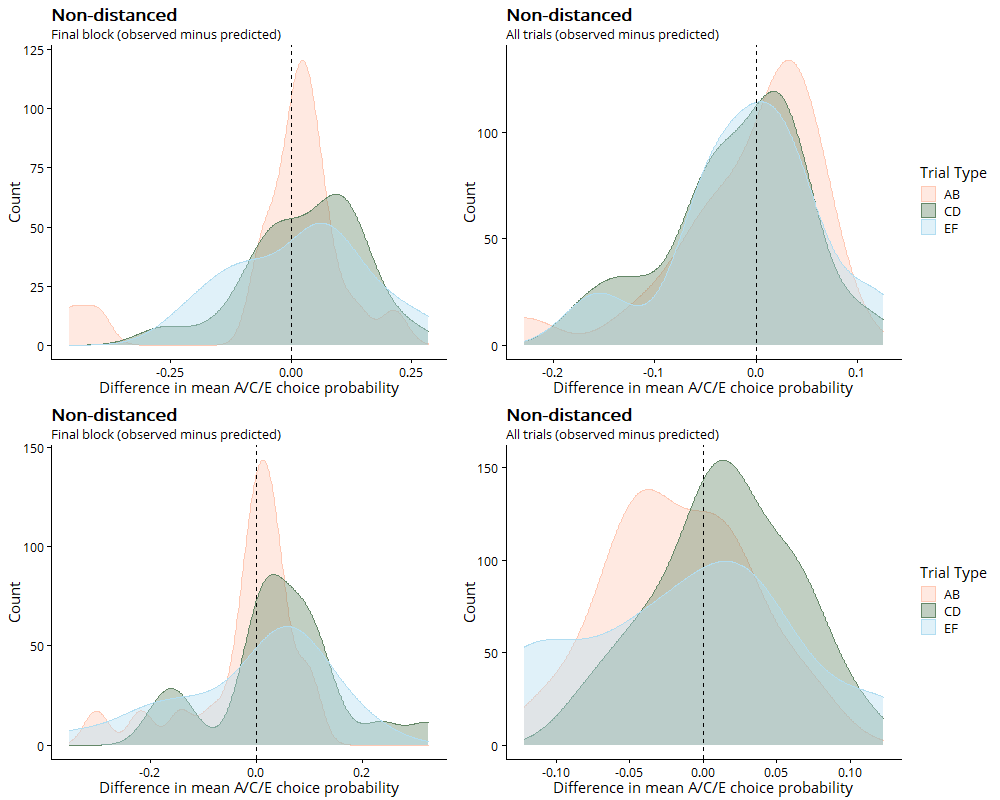

In [81]:
%%R -w 10 -h 8 --units in -r 100
legend <- cowplot::get_legend(
  pred_plts_2a_nd$diffs_obs_pred[[1]] + ggplot2::theme(
      legend.box.margin = ggplot2::margin(0, 0, 0, 8)
  )
)

cowplot::plot_grid(
    pred_plts_2a_nd$diffs_obs_pred[[1]] + 
        ggplot2::theme(legend.position="none") +
        ggplot2::ggtitle(
            "Non-distanced", 
            subtitle = "Final block (observed minus predicted)"
        ), 
    pred_plts_2a_nd$diffs_obs_pred[[2]] + 
        ggplot2::theme(legend.position="none") +
        ggplot2::ggtitle(
            "Non-distanced", 
            subtitle = "All trials (observed minus predicted)"
        ), 
    legend,
    pred_plts_2a_dis$diffs_obs_pred[[1]] + 
        ggplot2::theme(legend.position="none") +
        ggplot2::ggtitle(
            "Non-distanced", 
            subtitle = "Final block (observed minus predicted)"
        ), 
    pred_plts_2a_dis$diffs_obs_pred[[2]] + 
        ggplot2::theme(legend.position="none") +
        ggplot2::ggtitle(
            "Non-distanced", 
            subtitle = "All trials (observed minus predicted)"
        ), 
    legend,
    ncol = 3,
    nrow = 2,
    rel_widths = c(1,1,.2) 
)

These plots show the distributions of differences between the mean observed choice and the mean predicted choice for each trial type, over all trials and the final block (i.e., last 20 trials).

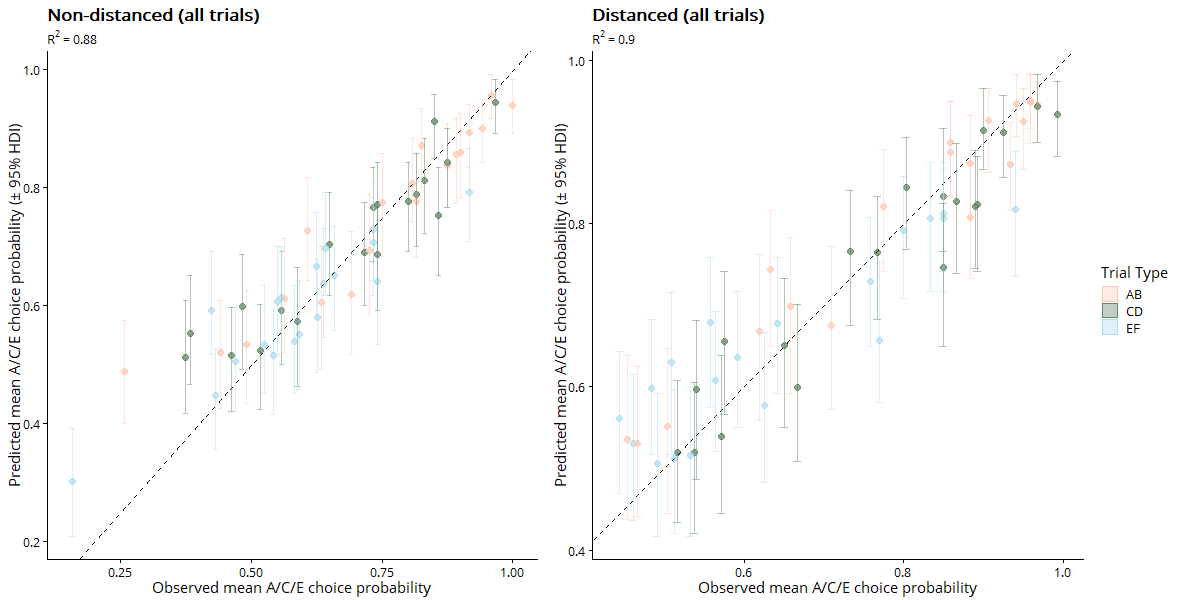

In [87]:
%%R -w 12 -h 6 --units in -r 100
legend <- cowplot::get_legend(
  pred_plts_2a_nd$diffs_obs_pred[[1]] + ggplot2::theme(
      legend.box.margin = ggplot2::margin(0, 0, 0, 8)
  )
)

cowplot::plot_grid(
    pred_plts_2a_nd$indiv_posteriors[[1]] + 
        ggplot2::theme(legend.position="none") +
        ggplot2::ggtitle("Non-distanced (all trials)"), 
    pred_plts_2a_dis$indiv_posteriors[[1]] + 
        ggplot2::theme(legend.position="none") +
        ggplot2::ggtitle("Distanced (all trials)"),  
    legend,
    ncol = 3,
    rel_widths = c(1,1,.2) 
)

These plots show the posterior means and 95% HDIs for the number of choices of each type over the whole task, across all posterior draws, plotted against the observed overall choice probabilities for each individual.

## 1 learning rate

The training phase of the PST may also be adequately modelled with a single learning-rate model, with a simple update equation for the state-action values: $Q_{t+1}(s_t, a_t) = Q_t(s_t, a_t) + \alpha\delta_t$. Evidence that this model fit our data better would indicate that recency effects (as captured by the learning rate $\alpha$) are not conditional on the type of feedback received.

In [88]:
%%R
subset_mcmc_1a_train_nd <- pstpipeline::fit_learning_model(
    nd_subsample, exp_part = "training", model = "1a", vb = FALSE, 
    save_model_as = "fit_pst_1a_nd_subsamp",
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj", 
                "diagnostics"),
    out_dir = "outputs/cmdstan/1a_subset/model_fits", refresh = 0, iter_warmup = 1000, 
    iter_sampling = 2000, adapt_delta = 0.9, step_size = 1, max_treedepth = 10, 
    font_size = 11, font = "Open Sans"
);

R[write to console]: Error in dplyr::select(., subjID, exclusion, final_block_AB) : 
  object 'nd_subsample' not found

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 




Error in dplyr::select(., subjID, exclusion, final_block_AB) : 
  object 'nd_subsample' not found


RInterpreterError: Failed to parse and evaluate line 'subset_mcmc_1a_train_nd <- pstpipeline::fit_learning_model(\n    nd_subsample, exp_part = "training", model = "1a", vb = FALSE, \n    save_model_as = "fit_pst_1a_nd_subsamp",\n    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj", \n                "diagnostics"),\n    out_dir = "outputs/cmdstan/1a_subset/model_fits", refresh = 0, iter_warmup = 1000, \n    iter_sampling = 2000, adapt_delta = 0.9, step_size = 1, max_treedepth = 10, \n    font_size = 11, font = "Open Sans"\n);\n'.
R error message: "Error in dplyr::select(., subjID, exclusion, final_block_AB) : \n  object 'nd_subsample' not found"

In [ ]:
subset_mcmc_1a_train_dis <- pstpipeline::fit_learning_model(
    dis_subsample, exp_part = "training", model = "1a", vb = FALSE, 
    save_model_as = "fit_pst_1a_dis_subsamp",
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj", 
                "diagnostics"),
    out_dir = "outputs/cmdstan/1a_subset/model_fits", refresh = 0, iter_warmup = 1000, 
    iter_sampling = 2000, adapt_delta = 0.9, step_size = 1, max_treedepth = 10, 
    font_size = 11, font = "Open Sans"
);

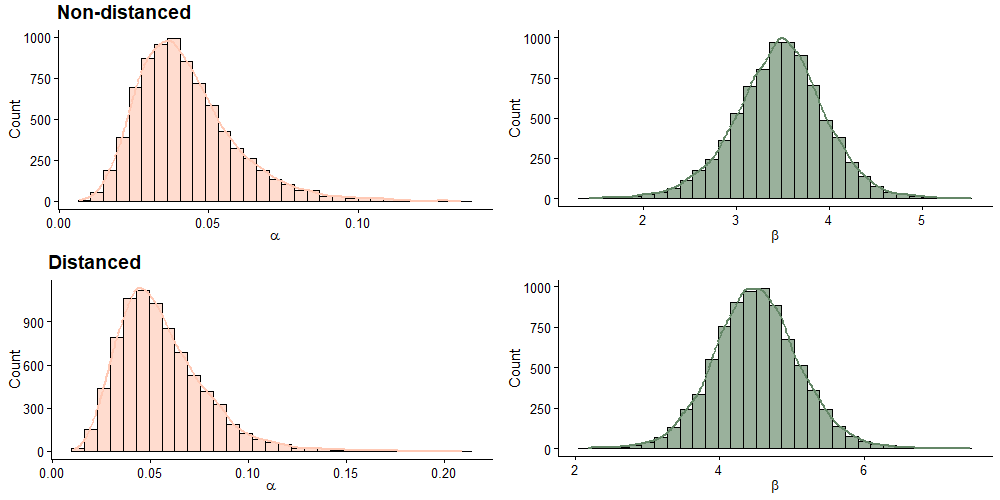

In [51]:
%%R -w 10 -h 5 --units in -r 100
cowplot::plot_grid(
    cowplot::ggdraw() + cowplot::draw_label(
        "Non-distanced", hjust = 3.3, fontface = "bold", size = 14, 
        fontfamily = "Open Sans"
    ),
    subset_mcmc_1a_train_nd$model_checks$mu_par_dens,
    cowplot::ggdraw() + cowplot::draw_label(
        "Distanced", hjust = 4.85, fontface = "bold", size = 14, 
        fontfamily = "Open Sans"
    ),
    subset_mcmc_1a_train_dis$model_checks$mu_par_dens,
    nrow = 4,
    rel_heights = c(0.1, 1, 0.1, 1)
)

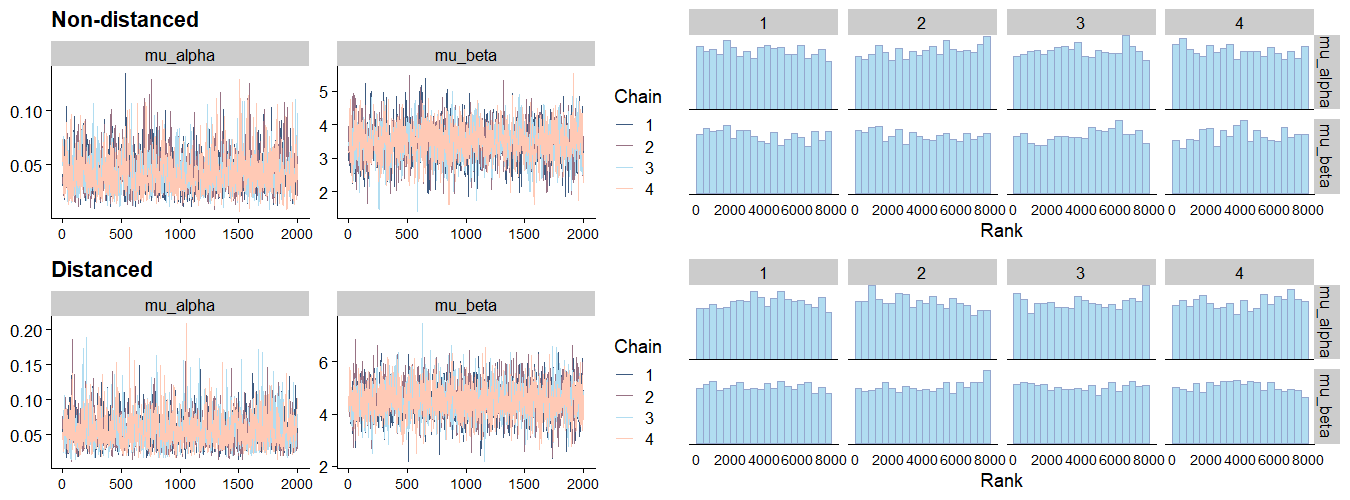

In [52]:
%%R -w 13.5 -h 5 --units in -r 100
cowplot::plot_grid(
    subset_mcmc_1a_train_nd$model_checks$diagnostics$trace + 
        ggplot2::ggtitle("Non-distanced") + 
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)), 
    subset_mcmc_1a_train_nd$model_checks$diagnostics$rank_hist +
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)),
    subset_mcmc_1a_train_dis$model_checks$diagnostics$trace + 
        ggplot2::ggtitle("Distanced") +
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)), 
    subset_mcmc_1a_train_dis$model_checks$diagnostics$rank_hist + 
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)),
    nrow = 2,
    ncol = 2
)

In [54]:
%%R
fit_nd_1a <- readRDS(
    "outputs/cmdstan/1a_subset/model_fits/fit_pst_1a_nd_subsamp_mcmc_8000.RDS"
)
data_list_nd_1a <- readRDS(
    "outputs/cmdstan/1a_subset/model_fits/fit_pst_1a_nd_subsamp_stan_datalist.RDS"
)

subset_gq_1a_train_nd <- pstpipeline::generate_posterior_quantities(
    fit_mcmc = fit_nd_1a, data_list = data_list_nd_1a,
    save_model_as = "fit_pst_1a_nd_subsamp", 
    out_dir = "outputs/cmdstan/1a_subset/predictions", return_type = "paths"
)

R[write to console]: Model executable is up to date!



Running standalone generated quantities after 4 MCMC chains, all chains in parallel ...

Chain 3 finished in 0.0 seconds.
Chain 1 finished in 0.0 seconds.
Chain 2 finished in 0.0 seconds.
Chain 4 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 14.4 seconds.


In [56]:
%%R
fit_dis_1a <- readRDS("outputs/cmdstan/1a_subset/model_fits/fit_pst_1a_dis_subsamp_mcmc_8000.RDS")
data_list_dis_1a <- readRDS("outputs/cmdstan/1a_subset/model_fits/fit_pst_1a_dis_subsamp_stan_datalist.RDS")

subset_gq_1a_train_nd <- pstpipeline::generate_posterior_quantities(
    fit_mcmc = fit_dis_1a, data_list = data_list_dis_1a,
    save_model_as = "fit_pst_1a_dis_subsamp", 
    out_dir = "outputs/cmdstan/1a_subset/predictions", return_type = "paths"
)

R[write to console]: Model executable is up to date!



Running standalone generated quantities after 4 MCMC chains, all chains in parallel ...

Chain 4 finished in 0.0 seconds.
Chain 1 finished in 0.0 seconds.
Chain 2 finished in 0.0 seconds.
Chain 3 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 18.6 seconds.
